In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [15]:
df_initial = pd.read_csv('./data.csv',
                         encoding='latin1',
                         dtype={
                             'CustomerID': str,
                             'InvoiceID': str
                         })
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
print('Dataframe dimensions:', df_initial.shape)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(
    pd.DataFrame(
        df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
tab_info = tab_info.append(
    pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] *
                 100).T.rename(index={0: 'null values (%)'}))
print(tab_info)

Dataframe dimensions: (541909, 8)
                 InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)        0.0       0.0    0.268311      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)        0.0  24.926694     0.0  


In [16]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [17]:
# Remove entries for customer ID NULL
df_initial.dropna(axis=0, subset=['CustomerID'], inplace=True)
print('Dataframe dimensions:', df_initial.shape)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(
    pd.DataFrame(
        df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
tab_info = tab_info.append(
    pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] *
                 100).T.rename(index={0: 'null values (%)'}))
print(tab_info)

Dataframe dimensions: (406829, 8)
                 InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)        0.0        0.0     0.0  


In [18]:
df_initial.drop_duplicates(inplace=True)


In [19]:
country_to_index = {}
count = 0
countries = df_initial["Country"].to_numpy()
for i in range(countries.shape[0]):
    if countries[i] not in country_to_index:
        country_to_index[countries[i]] = count
        count += 1
print(count)
print(country_to_index)

37
{'United Kingdom': 0, 'France': 1, 'Australia': 2, 'Netherlands': 3, 'Germany': 4, 'Norway': 5, 'EIRE': 6, 'Switzerland': 7, 'Spain': 8, 'Poland': 9, 'Portugal': 10, 'Italy': 11, 'Belgium': 12, 'Lithuania': 13, 'Japan': 14, 'Iceland': 15, 'Channel Islands': 16, 'Denmark': 17, 'Cyprus': 18, 'Sweden': 19, 'Austria': 20, 'Israel': 21, 'Finland': 22, 'Greece': 23, 'Singapore': 24, 'Lebanon': 25, 'United Arab Emirates': 26, 'Saudi Arabia': 27, 'Czech Republic': 28, 'Canada': 29, 'Unspecified': 30, 'Brazil': 31, 'USA': 32, 'European Community': 33, 'Bahrain': 34, 'Malta': 35, 'RSA': 36}


In [20]:
df_initial = df_initial.drop("Country", 1)

/tmp/ipykernel_45812/543043970.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_initial = df_initial.drop("Country", 1)


In [21]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850


In [22]:
for i in range(countries.shape[0]):
    countries[i] = country_to_index[countries[i]]
df_initial["CountryID"] = countries
df_initial.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,1


In [23]:
df_phase2 = df_initial
df_phase2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1


In [24]:
pd.DataFrame([{
    'products': len(df_initial['StockCode'].value_counts()),
    'transactions': len(df_initial['InvoiceNo'].value_counts()),
    'customers': len(df_initial['CustomerID'].value_counts()),
}],
             columns=['products', 'transactions', 'customers'],
             index=['quantity'])


,products,transactions,customers
quantity,3684,22190,4372


In [25]:
# Grouping Rows if they belong to same invoice no and customer id
temp = df_phase2.groupby(by=['CustomerID', 'InvoiceNo'],
                         as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(
    columns={'InvoiceDate': 'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [148]:
df_cleaned = df_phase2.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in df_phase2.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_phase2[(df_phase2['CustomerID'] == col['CustomerID'])
                        & (df_phase2['StockCode'] == col['StockCode']) &
                        (df_phase2['InvoiceDate'] < col['InvoiceDate']) &
                        (df_phase2['Quantity'] > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)

    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break


In [149]:
df_cleaned.to_csv("df_cleaned.csv")

In [ ]:
print(len(doubtfull_entry))

In [150]:
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)


In [151]:
print(df_cleaned.shape)

(392857, 9)


In [26]:
df_phase3 = pd.read_csv("df_phase3.csv",encoding='latin1')

In [ ]:
df_phase3 = df_cleaned

In [28]:
to_remove = []
for i, val in df_phase3.iterrows():
    if val["Quantity"] <= 0:
        to_remove.append(i)
print(len(to_remove))

0


In [29]:
df_phase3.drop(to_remove, axis=0, inplace=True)


In [30]:
df_phase3["TotalPrice"] = df_phase3["UnitPrice"] * (
    df_phase3["Quantity"] - df_phase3["QuantityCanceled"])
df_phase3

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID,QuantityCanceled,TotalPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0,0,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0,0,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
...,...,...,...,...,...,...,...,...,...,...,...
392727,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1,0,10.20
392728,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1,0,12.60
392729,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60
392730,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60


In [31]:
temp = df_phase3.groupby(by=['CustomerID', 'InvoiceNo'],
                         as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})
basket_price = basket_price[basket_price["Basket Price"] > 0]
basket_price.head()

,CustomerID,InvoiceNo,Basket Price
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52
5,12347,562032,584.91


In [32]:
df_phase3.to_csv("df_phase3.csv")

In [33]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lem = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/vaibhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vaibhav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/vaibhav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
root_freq = {}
stock_to_roots = {}
root_to_index = {}
count = 0


def is_noun(pos):
    if pos[:2] == 'NN':
        return True
    return False


for i, row in df_phase3.iterrows():
    desc = row["Description"]
    if pd.isnull(desc):
        continue
    desc = desc.lower()
    stock = row["StockCode"]
    tokens = nltk.word_tokenize(desc)
    nouns = [word for (word, pos) in nltk.pos_tag(tokens) if is_noun(pos)]
    vis = {}
    temp = []
    for noun in nouns:
        noun = noun.lower()
        root = lem.lemmatize(noun)
        if root not in root_freq:
            root_freq[root] = 1
            vis[root] = 1
            temp.append(root)
            root_to_index[root] = count
            count += 1
        elif root not in vis:
            root_freq[root] += 1
            vis[root] = 1
            temp.append(root)
    stock_to_roots[stock] = temp

print(root_freq)

In [35]:
threshold = 1400
print(len(root_freq))
top_roots = {key: val for key, val in root_freq.items() if val >= threshold}
print(len(top_roots))

1498
185


In [ ]:
c = 0
pop_root_to_index = {}
for key, val in top_roots.items():
    pop_root_to_index[key] = c
    c += 1
print(pop_root_to_index)

In [37]:
list_products = df_phase3["StockCode"].unique()

In [38]:
products_np = []
mean_prices = []
count_cat = [0 for _ in range(6)]
for i, stock in enumerate(list_products):
    desc = df_phase3[df_phase3["StockCode"] == stock]["Description"].iloc[0]
    temp = [stock, desc]
    roots = stock_to_roots[stock]
    t = [0 for i in range(len(top_roots))]
    for root in roots:
        if root in top_roots:
            index = pop_root_to_index[root]
            t[index] = 1
    temp.extend(t)
    mean_price = df_phase3[df_phase3["StockCode"] == stock]["UnitPrice"].mean()
    prod_cat = 0

    if mean_price < 1:
        prod_cat = 0
    elif mean_price < 2:
        prod_cat = 1
    elif mean_price < 3:
        prod_cat = 2
    elif mean_price < 5:
        prod_cat = 3
    elif mean_price < 10:
        prod_cat = 4
    else:
        prod_cat = 5

    cat_list = [0 for _ in range(6)]
    cat_list[prod_cat] = 1
    temp.extend(cat_list)
    mean_prices.append(mean_price)
    count_cat[prod_cat] += 1
    temp = np.array(temp)
    # print(temp.shape)
    products_np.append(temp)

0.00075


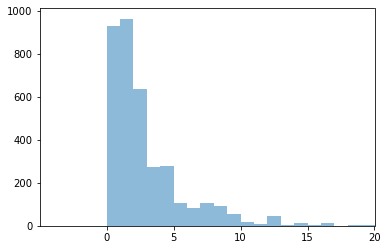

In [39]:
bins = np.arange(-100, 100, 1)  # fixed bin size
print(min(mean_prices))
plt.xlim([min(mean_prices) - 5, 20])

plt.hist(mean_prices, bins=bins, alpha=0.5)
plt.show()


In [40]:
count_cat = np.array(count_cat)
for i in range(6):
    print(count_cat[i] / np.sum(count_cat) * 100, "%")


25.34788540245566 %
26.302864938608455 %
17.32605729877217 %
15.061391541609822 %
11.950886766712141 %
4.0109140518417465 %


In [41]:
products_np = np.array(products_np)
print(products_np.shape)

(3665, 193)


In [42]:
cols = ["StockCode", "Description"]
for i in range(185):
    cols.append("root-" + str(i + 1))
for i in range(6):
    cols.append("priceRange-" + str(i + 1))
df_products = pd.DataFrame(products_np, columns=cols)
df_products.to_csv("df_products.csv")

In [43]:
df_products = pd.read_csv("df_products.csv", encoding="latin1")


In [44]:
df_inp = df_products.drop(["StockCode", "Description", df_products.columns[0]],
                          axis=1)
prod_np = df_inp.to_numpy().astype('int64')


In [49]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=7, n_init=1)
kmeans.fit(prod_np)
clusters = kmeans.predict(prod_np)

print(pd.Series(clusters).value_counts())

2    1076
5     925
0     622
3     510
4     404
1      97
6      31
dtype: int64


In [50]:
print(pd.Series(clusters).value_counts())

2    1076
5     925
0     622
3     510
4     404
1      97
6      31
dtype: int64


In [51]:
print(df_phase3.shape, len(clusters))


(392732, 11) 3665


In [52]:
df_phase4 = df_products[["StockCode", "Description"]]
df_phase4["Category"] = clusters
print(df_phase4)


     StockCode                          Description  Category
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER         0
1        71053                  WHITE METAL LANTERN         3
2       84406B       CREAM CUPID HEARTS COAT HANGER         3
3       84029G  KNITTED UNION FLAG HOT WATER BOTTLE         3
4       84029E       RED WOOLLY HOTTIE WHITE HEART.         3
...        ...                                  ...       ...
3660    90214U            LETTER "U" BLING KEY RING         5
3661    90214W            LETTER "W" BLING KEY RING         5
3662    90214Z            LETTER "Z" BLING KEY RING         5
3663     90089       PINK CRYSTAL SKULL PHONE CHARM         5
3664     23843          PAPER CRAFT , LITTLE BIRDIE         0

[3665 rows x 3 columns]


/tmp/ipykernel_45812/2862190089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phase4["Category"] = clusters


In [53]:
df_phase4.to_csv("final_prod_cat.csv")

In [ ]:
stock_to_cat = {}

for i, row in df_phase4.iterrows():
    stock_to_cat[row["StockCode"]] = row["Category"]

print(stock_to_cat)

In [55]:
stock_list = df_phase3["StockCode"].to_numpy()
cat_list = []
for i in range(stock_list.shape[0]):
    cat_list.append(stock_to_cat[stock_list[i]])

df_phase3["prod_cat"] = cat_list


In [56]:
df_phase3_np = df_phase3.to_numpy()

In [ ]:
print(df_phase3)

In [58]:
df_phase5 = []
for i in range(df_phase3_np.shape[0]):
    temp = [0, 0, 0, 0, 0, 0, 0]
    cat = df_phase3_np[i][-1]
    temp[cat] = df_phase3_np[i][-2]
    res = list(df_phase3_np[i]) + temp
    df_phase5.append(np.array(res))

df_phase5_np = np.array(df_phase5)
print(df_phase5_np)


[['0' '536365' '85123A' ... '0' '0' '0']
 ['1' '536365' '71053' ... '0' '0' '0']
 ['2' '536365' '84406B' ... '0' '0' '0']
 ...
 ['541906' '581587' '23254' ... '0' '0' '0']
 ['541907' '581587' '23255' ... '0' '0' '0']
 ['541908' '581587' '22138' ... '0' '0' '0']]


In [59]:
cols = list(df_phase3.columns)
cols.extend(["cat0", "cat1", "cat2", "cat3", "cat4", "cat5", "cat6"])
df_phase6 = pd.DataFrame(df_phase5_np, columns=cols)
print(df_phase6)

       Unnamed: 0 InvoiceNo StockCode                          Description  \
0               0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1               1    536365     71053                  WHITE METAL LANTERN   
2               2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3               3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4               4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
...           ...       ...       ...                                  ...   
392727     541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS   
392728     541905    581587     22899         CHILDREN'S APRON DOLLY GIRL    
392729     541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
392730     541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
392731     541908    581587     22138        BAKING SET 9 PIECE RETROSPOT    

       Quantity          InvoiceDate UnitPrice CustomerID Count

In [60]:
df_phase6.to_csv("df_phase6.csv")

In [61]:
df_phase6 = pd.read_csv("df_phase6.csv", encoding="latin1")


In [ ]:
invoice_to_cats = {}
for i, row in df_phase6.iterrows():
    invoice = row["InvoiceNo"]
    if invoice in invoice_to_cats:
        invoice_to_cats[invoice][3] += row["cat0"]
        invoice_to_cats[invoice][4] += row["cat1"]
        invoice_to_cats[invoice][5] += row["cat2"]
        invoice_to_cats[invoice][6] += row["cat3"]
        invoice_to_cats[invoice][7] += row["cat4"]
        invoice_to_cats[invoice][8] += row["cat5"]
        invoice_to_cats[invoice][9] += row["cat6"]
        invoice_to_cats[invoice][10] += row["TotalPrice"]
    else:
        invoice_to_cats[invoice] = list([
            row["CustomerID"], row["InvoiceNo"], row["CountryID"], row["cat0"],
            row["cat1"], row["cat2"], row["cat3"], row["cat4"],row["cat5"],row["cat6"],
            row["TotalPrice"]
        ])

print(invoice_to_cats)

In [ ]:
df_phase7 = []
for key, val in invoice_to_cats.items():
    if val[-1] > 0:
        df_phase7.append(val)

print(df_phase7)

In [ ]:
cust_to_invoice = {}

for i, row in enumerate(df_phase7):
    cust = row[0]
    if cust in cust_to_invoice:
        cust_to_invoice[cust][2] += row[3]
        cust_to_invoice[cust][3] += row[4]
        cust_to_invoice[cust][4] += row[5]
        cust_to_invoice[cust][5] += row[6]
        cust_to_invoice[cust][6] += row[7]
        cust_to_invoice[cust][7] += row[8]
        cust_to_invoice[cust][8] += row[9]
        cust_to_invoice[cust][9] += row[10]
        cust_to_invoice[cust][10] = min({cust_to_invoice[cust][10], row[9]})
        cust_to_invoice[cust][11] = max(cust_to_invoice[cust][11], row[9])
        cust_to_invoice[cust][12] += 1
        if cust_to_invoice[cust][10] < 0:
            cust_to_invoice[cust][10] = 0
    else:
        cust_to_invoice[cust] = list([
            row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9],
            row[10], row[10], row[10], 1
        ])

print(cust_to_invoice)

In [92]:
df_phase8 = []
for key, val in cust_to_invoice.items():
    val2 = [val[i] for i in range(len(val))]
    val2.append(val[9] / (val[-1] + 0.5))
    for i in range(2, 9):
        if val[9] != 0:
            val2[i] /= (val2[9] + 0.5)
            val2[i] *= 100
        else:
            val2[i] = 0
    df_phase8.append(val2)

print(len(df_phase8[0]))
# Original Order: Customer ID, Country ID, Cat-0, Cat-1, Cat-2, Cat-3, Cat-4, Cat-5, Cat-6, Total, Min, Max, Mean, Frequency

14


In [93]:
cols = [
    "CustomerID", "CountryID", "Category-0", "Category-1", "Category-2",
    "Category-3", "Category-4","Category-5","Category-6", "Total Expenditure", "Min Expenditure",
    "Max Expenditure", "No. of Invoices", "Mean Expenditure"
]
df_phase9 = pd.DataFrame(df_phase8, columns=cols)
print(df_phase9)

      CustomerID  CountryID  Category-0  Category-1  Category-2  Category-3  \
0          17850          0   22.570416    0.000000   18.684698   35.199518   
1          13047          0   15.249814    5.017279   17.911055   29.209056   
2          12583          1   15.876814    0.740139   31.791331   28.283184   
3          13748          0   60.850593    3.098814   25.364954    5.080369   
4          15100          0    0.000000    0.000000   99.921334    0.000000   
...          ...        ...         ...         ...         ...         ...   
4322       13436          0   17.903643   12.108010   27.433001   23.202796   
4323       15520          0   53.965116    0.000000   27.488372    2.877907   
4324       13298          0    0.000000    0.000000    0.000000   99.861304   
4325       14569          0   59.590153    0.000000    8.139892   27.684409   
4326       12713          4    9.615453   12.095872   43.707673   24.798304   

      Category-4  Category-5  Category-6  Total Exp

In [94]:
df_phase9.to_csv("df_phase9.csv")

In [95]:
df_phase9 = pd.read_csv("df_phase9.csv", encoding="latin1")
df_phase9.drop("CustomerID", axis=1, inplace=True)
df_phase9.drop("CountryID", axis=1, inplace=True)


In [96]:
df_phase9.max()

Unnamed: 0             4326.000000
Category-0               99.987052
Category-1               99.915326
Category-2               99.987673
Category-3               99.971999
Category-4               99.984120
Category-5               99.992767
Category-6               46.259220
Total Expenditure    279765.020000
Min Expenditure        6207.670000
Max Expenditure       19710.000000
No. of Invoices         205.000000
Mean Expenditure       9940.360000
dtype: float64

In [97]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10000)
kmeans.fit(df_phase9)
clusters = kmeans.predict(df_phase9)
print(pd.Series(clusters).value_counts())

5    2197
0    1887
4     209
3      27
1       4
2       3
dtype: int64


In [98]:
print(list(pd.Series(clusters).value_counts()))

[2197, 1887, 209, 27, 4, 3]


In [99]:
df_phase9.max()

Unnamed: 0             4326.000000
Category-0               99.987052
Category-1               99.915326
Category-2               99.987673
Category-3               99.971999
Category-4               99.984120
Category-5               99.992767
Category-6               46.259220
Total Expenditure    279765.020000
Min Expenditure        6207.670000
Max Expenditure       19710.000000
No. of Invoices         205.000000
Mean Expenditure       9940.360000
dtype: float64

In [100]:
df_phase9.drop(df_phase9.columns[0], axis=1, inplace=True)


In [101]:
k = 6
centers = [[0 for i in range(df_phase9.shape[1])] for j in range(k)]

count = [0 for _ in range(k)]
for i, row in df_phase9.iterrows():
    cur = clusters[i]
    count[cur] += 1
    for j in range(df_phase9.shape[1]):
        centers[cur][j] += row[j]
centers = np.array(centers)
for i in range(k):
    centers[i] /= count[i]

print(centers)

[[2.14563774e+01 3.69955749e+00 3.11492632e+01 1.58364391e+01
  1.37645483e+01 1.32745128e+01 7.19430837e-01 1.52761603e+03
  6.38285321e+01 3.75147621e+02 4.73873874e+00 2.96778910e+02]
 [2.18185638e+01 4.94566203e+00 2.99548617e+01 1.95379437e+01
  1.18282777e+01 1.12746758e+01 6.39571953e-01 1.15734193e+05
  0.00000000e+00 2.41930750e+03 7.57500000e+01 2.99563895e+03]
 [2.28691017e+01 3.94275818e+00 2.14885301e+01 2.02783142e+01
  2.19915693e+01 6.10348332e+00 3.32603327e+00 2.44279983e+05
  0.00000000e+00 7.03738667e+03 5.96666667e+01 4.08590064e+03]
 [2.91688696e+01 3.06304332e+00 2.83100052e+01 1.63863078e+01
  1.12121150e+01 1.13823689e+01 4.75971922e-01 4.22869522e+04
  0.00000000e+00 1.25430519e+03 4.72222222e+01 1.37000294e+03]
 [2.32433281e+01 4.57036105e+00 2.89809443e+01 1.76034323e+01
  1.45593250e+01 1.06065309e+01 4.29776601e-01 9.09695957e+03
  5.30214354e+01 1.00844211e+03 1.65933014e+01 8.15540909e+02]
 [1.98697324e+01 3.72091140e+00 3.20857132e+01 1.59299133e+01
  1

In [263]:
print(centers[3][1])

15.232961590085395


In [264]:
print(np.array(centers[:, 0]))


[1.32203556e+02 3.68526257e+03 5.98540146e+00 2.86428571e+02
 1.44106133e+05 4.69633333e+03]


In [277]:
# temp[4]=0

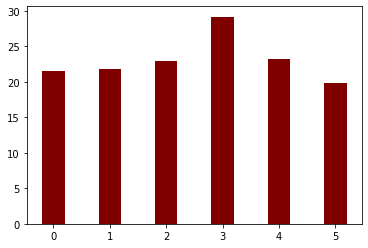

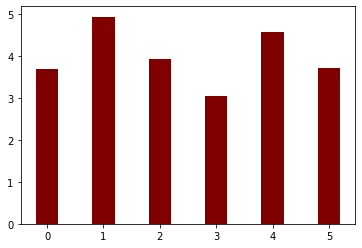

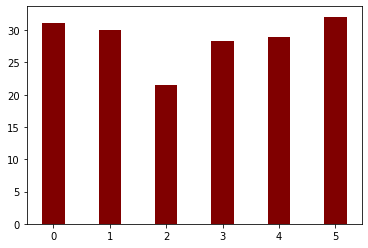

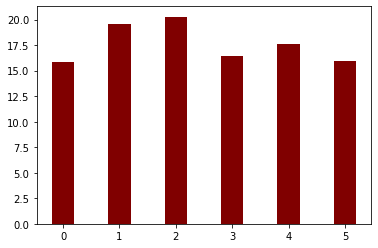

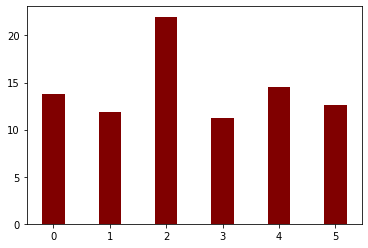

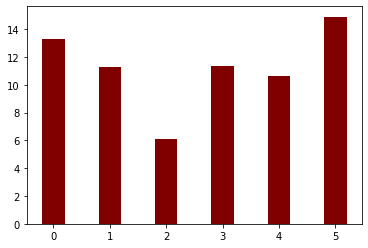

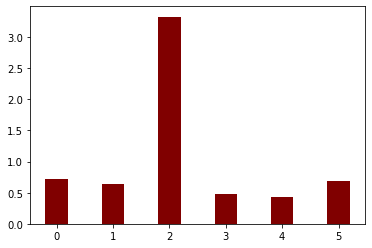

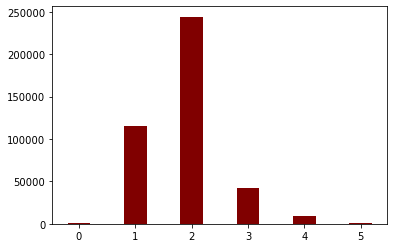

In [103]:
for j in range(8):
    temp = centers[:, j]
    plt.bar([i for i in range(6)], temp, color='maroon', width=0.4)
    plt.show()


In [104]:
cust_to_clust = {}
for i,val in enumerate(df_phase8):
    cust_to_clust[val[0]] = clusters[i]

In [112]:
df_phase3.drop(df_phase3.columns[0],axis=1,inplace=True)

In [113]:
cust_cat = []
for i,val in df_phase3.iterrows():
    if int(val[6]) in cust_to_clust:
        cust_cat.append(cust_to_clust[int(val[6])])
    else:
        cust_cat.append(-1)
df_phase3["customer cluster"] = cust_cat

In [114]:
word_cloud_dicts = [dict() for _ in range(6)]
for i,row in df_phase3.iterrows():
    clust = row["customer cluster"]
    for j,root in enumerate(stock_to_roots[row["StockCode"]]):
        if root in word_cloud_dicts[clust]:
            word_cloud_dicts[clust][root]+=1
        else:
            word_cloud_dicts[clust][root]=1

In [115]:
for i in range(6):
    print(len(word_cloud_dicts[i]))

1431
1012
580
1245
1285
1360


In [116]:
from wordcloud import WordCloud, STOPWORDS

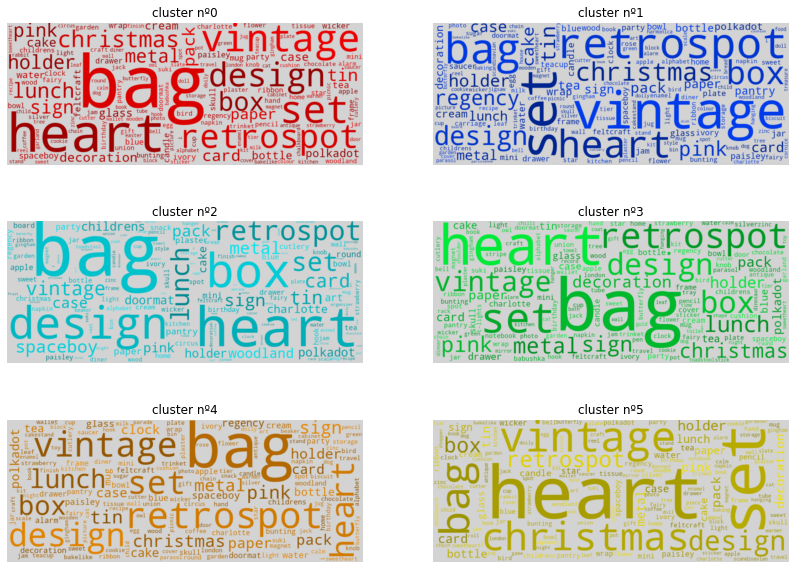

In [117]:
n_clusters = 6

#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    tone = color[i] 
    liste = []
    for key, value in word_cloud_dicts[i].items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

